In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/initno

/content/drive/MyDrive/initno


In [3]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement cudatoolkit==11.3.1 (from versions: none)
ERROR: No matching distribution found for cudatoolkit==11.3.1


In [ ]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

12.4
True


In [4]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"

In [5]:
!pip install --upgrade diffusers

In [ ]:
%cd /content/drive/MyDrive/initno
import os
print(os.getcwd())

/content/drive/MyDrive/initno
/content/drive/MyDrive/initno


In [6]:
import os,shutil
import torch
import openai,re
import sys
sys.path.append("/content/drive/MyDrive/initno")  # Add the correct path
from initno.pipelines.pipeline_sd_initno import StableDiffusionInitNOPipeline
import random
from typing import List, Dict
import torch
import tqdm
import sys,os,shutil
# sys.path.append(".")
# sys.path.append("..")
from utils.ptp_utils import AttentionStore
# ---------
# Arguments
# ---------
# SEEDS           = [random.randint(1, 1000) for _ in range(50)]
# print(SEEDS)
SEEDS=[0]
SD14_VERSION    = "CompVis/stable-diffusion-v1-4"
SD15_VERSION    = "runwayml/stable-diffusion-v1-5"
SD21_VERSION    = "stabilityai/stable-diffusion-2-1-base"
PROMPT          = "a cow and a buffalo. The Image should be realistic"

token_indices  = [2,5]
result_root     = "results"
pipe = StableDiffusionInitNOPipeline.from_pretrained(SD21_VERSION, torch_dtype=torch.float16).to("cuda")
# output_folder_name=PROMPT.replace(" ","_")
# if os.path.exists("outputs/"+output_folder_name) and os.path.isdir("outputs/"+output_folder_name):
#    # Delete the folder
#     shutil.rmtree("outputs/"+output_folder_name)
# os.makedirs("outputs/"+output_folder_name, exist_ok = True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/lora_pipeline.py:3811: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)


In [ ]:
prompts=["a bear with a glasses",
        "a blue balloon and a orange bench",
        "a pink crown and a red chair",
        "a monkey and a red car",
        "a elephant with a bow",
        "a frog and a purple balloon",
         "a pink crown and a purple bow",
        "a blue clock and a blue apple",
]

In [7]:
prompts=["a grizzly bear catching a salmon from a clear river surrounded by a forest"]

In [ ]:
import os
print(os.path.exists("/content/drive/MyDrive/initno/initno/pipelines/pipeline_sd_initno.py"))


True


In [8]:
import openai
import re
from transformers import CLIPTokenizer

SEEDS=[i for i in range(3)]
def GPT_4_call(prompt):
    response = openai.ChatCompletion.create(
                    messages=[
                    {"role": "system", "content": prompt},
                    ],
                    engine='gpt-4-32k',
                    request_timeout=120,
                    api_key='41a6eb9d201a44dfa58e2a36fe6fb5a4',
                    api_version="2023-05-15",
                    api_type='azure',
                    api_base='https://gpt4-docexpresearch.openai.azure.com/'
                )
    return response['choices'][0]['message']['content']

for prompt in prompts:
    token_indices=[3,6,10,14]
    # output_folder_name=prompt.replace(" ","_")
    output_folder_name=prompt
    if os.path.exists("./outputs/"+output_folder_name) and os.path.isdir("outputs/"+output_folder_name):
           # Delete the folder
            shutil.rmtree("./outputs/"+output_folder_name)
    os.makedirs("./outputs/"+output_folder_name, exist_ok = True)
    for SEED in SEEDS:
        print('Seed ({}) Processing the ({}) prompt'.format(SEED, prompt))
        generator = torch.Generator("cuda").manual_seed(SEED)
        images = pipe(
            prompt=prompt,
            token_indices=token_indices,
            guidance_scale=7.5,
            # negative_prompt="Cropped, Out of frame, Out of focus,Bad anatomy, Bad proportions, Deformed, Disconnected limbs, Disfigured, Extra arms, Extra limbs, Extra hands, Fused fingers, Gross proportions, Long neck, Malformed limbs, Mutated, Mutated hands, Mutated limbs, Missing arms, Missing fingers, Poorly drawn hands, Poorly drawn face, ugly",
            generator=generator,
            num_inference_steps=50,
            max_iter_to_alter=25,
            result_root=result_root,
            seed=SEED,
            run_sd=False,
            run_initno=True
        ).images
        image = images[0]
        image.save(f"./outputs/{output_folder_name}/{SEED}.jpg","JPEG")

Seed (0) Processing the (a grizzly bear catching a salmon from a clear river surrounded by a forest) prompt


  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 47%|████▋     | 7/15 [01:02<01:11,  8.97s/it]


Early stopping at iteration 7


 87%|████████▋ | 13/15 [01:22<00:12,  6.38s/it]


Early stopping at iteration 13


 26%|██▌       | 13/50 [01:29<04:14,  6.89s/it]

Early stopping at iteration 13


  0%|          | 0/50 [00:00<?, ?it/s]

Seed (1) Processing the (a grizzly bear catching a salmon from a clear river surrounded by a forest) prompt


 73%|███████▎  | 11/15 [01:04<00:23,  5.83s/it]


Early stopping at iteration 11


 53%|█████▎    | 8/15 [10:59<09:36, 82.41s/it]


KeyboardInterrupt: 

In [10]:
import abc

import cv2
import numpy as np
import torch
from IPython.display import display
from PIL import Image
from typing import Union, Tuple, List
from transformers import CLIPTokenizer
import seaborn as sns
def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)) -> np.ndarray:
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y), font, 1, text_color, 2)
    return img
def prompt_tokenizer(prompt):
    # Initialize the CLIP tokenizer
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    # Tokenize the text prompt
    tokens = tokenizer.tokenize(prompt)
    # Put the tokens in a list
    tokens_list = list(tokens)
    tokens_list=[token.replace('</w>', '') for token in tokens_list]
    print(tokens_list)
    return tokens_list
def view_images(images: Union[np.ndarray, List],
                num_rows: int = 1,
                offset_ratio: float = 0.02,
                display_image: bool = True) -> Image.Image:
    """ Displays a list of images in a grid. """
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    if display_image:
        display(pil_img)
    return pil_img
#CA_maps=np.load("/sensei-fs/tenants/Sensei-AdobeResearchTeam/share-aishagar/newintern/CLIP/Attend-and-Excite/initno/results/a cow and a buffalo/cross_attention_maps_a cow and a buffalo_0.npy")

def show_image_relevance(image_relevance, image: Image.Image, relevnace_res=16):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image = image.resize((relevnace_res ** 2, relevnace_res ** 2))
    image = np.array(image)
    image_relevance = torch.tensor(image_relevance).float()
    # image_relevance = image_relevance.reshape(1, 1, image_relevance.shape[-1], image_relevance.shape[-1])
    # image_relevance = image_relevance.cuda() # because float16 precision interpolation is not supported on cpu
    # image_relevance = torch.nn.functional.interpolate(image_relevance, size=relevnace_res ** 2, mode='bilinear')
    # image_relevance = image_relevance.cpu() # send it back to cpu

    image_relevance = torch.tensor(image_relevance, dtype=torch.float32, device="cpu")
    image_relevance = image_relevance.reshape(1, 1, image_relevance.shape[-1], image_relevance.shape[-1])
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=relevnace_res ** 2, mode='bilinear')

    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image_relevance = image_relevance.reshape(relevnace_res ** 2, relevnace_res ** 2)
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis
def plot_heatmap(attention_map, title="Attention Map"):
        # Convert to numpy array if it's a tensor
        if isinstance(attention_map, torch.Tensor):
            attention_map = attention_map.detach().cpu().numpy()

        # Ensure the map is 2D
        if attention_map.ndim != 2:
            raise ValueError("Attention map must be a 2D array or tensor.")

        plt.figure(figsize=(5,5))
        sns.heatmap(attention_map, cmap='coolwarm', annot=False, cbar=True)
        plt.title(title)
        plt.show()
def show_cross_attention(prompt: str,
                         CA_maps_path: str,
                         indices_to_alter: List[int],
                         res: int,
                         from_where: List[str],
                         select: int = 0,
                         orig_image=None):
    tokens = prompt_tokenizer(prompt)
    if CA_maps_path.endswith('.pt'):
        # Load the PyTorch tensor
        device = torch.device("cpu")  # Force CPU
        tensor = torch.load(CA_maps_path, map_location=device)
        # tensor = torch.load(CA_maps_path)
        # Convert the tensor to a NumPy array
        attention_maps = tensor.numpy()
    elif CA_maps_path.endswith('.npy'):
        # Load the NumPy array
        attention_maps = np.load(CA_maps_path)
    gen_image = Image.open(orig_image).convert('RGB')
    images = []
    # show spatial attention for indices of tokens to strengthen
    for j in range(49,50):
      images = []
      for i in range(len(tokens)):
          image = attention_maps[j, res*i:res*i+res,:]
          if i+1 in indices_to_alter:
              # if (i+1==2):
              #     for j in range(8,15):
              #         for k in range(0,9):
              #             image[j,k]=image[0,0]
              #             print(image[j,k],image[0,0])
              # plot_heatmap(image)
              image = show_image_relevance(image, gen_image)
              image = image.astype(np.uint8)
              image = np.array(Image.fromarray(image).resize((res ** 2, res ** 2)))
              image = text_under_image(image, tokens[i])
              images.append(image)
      view_images(np.stack(images, axis=0))
      print()
    return attention_maps

PCA+clustering and self-attention segment operations

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import label
import numpy as np
from sklearn.cluster import KMeans

def sigmoid(x):
    return 1 / (1 + np.exp(-16*(x)+10))

def mod_sigmoid(SA_map):
    return sigmoid(SA_map)

def otsu_thresholding(array):
    # Convert array to a format suitable for OpenCV (e.g., uint8)
    array_uint8 = (array * 255).astype(np.uint8)

    # Calculate Otsu's threshold
    otsu_threshold, _ = cv2.threshold(array_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply 1.5 times the Otsu threshold
    custom_threshold = otsu_threshold
    _, binary_array = cv2.threshold(array_uint8, custom_threshold, 255, cv2.THRESH_BINARY)

    # Convert the result back to a binary array
    binary_array = (binary_array / 255).astype(int)
    return binary_array

def separate_islands(binary_map,res):
    # Label the connected components (islands) in the binary map
    labeled_map, num_features = label(binary_map)

    # Create an array to store each island separately
    separated_maps = np.zeros((num_features, res,res), dtype=int)

    # Iterate over each island and create separate maps
    for i in range(1, num_features + 1):
        separated_maps[i - 1] = (labeled_map == i).astype(int)

    return separated_maps
# Function to calculate intersection between a self-attention segment and a cross-attention map
def calculate_intersection(segment, cross_attention_map):

    return np.sum(segment*cross_attention_map)
    #return np.sum(np.logical_and(segment, cross_attention_map))

# Function to create a cost matrix
def create_cost_matrix(self_attention_segments, cross_attention_maps):
    num_segments = len(self_attention_segments)
    num_nouns = len(cross_attention_maps)
    cost_matrix = np.zeros((num_segments, num_nouns))
    for i in range(num_segments):
        for j in range(num_nouns):
            cost_matrix[i, j] = -calculate_intersection(self_attention_segments[i], cross_attention_maps[j])
    return cost_matrix

# Function to assign segments to nouns
def assign_segments_to_nouns(self_attention_segments, cross_attention_maps):
    cost_matrix = create_cost_matrix(self_attention_segments, cross_attention_maps)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignments = list(zip(row_ind, col_ind))
    return assignments



def visualize_SA_map(attn_map, k_clusters=5):
    """
    Visualizes the self-attention map using PCA and K-Means clustering.

    Parameters:
    - attn_map: np.array of shape (16, 16, 256) representing self-attention.
    - k_clusters: Number of clusters for segmentation.
    """
    H, W, C = attn_map.shape  # Should be (16, 16, 256)
    attn_reshaped = attn_map.reshape(-1, C)  # Flatten spatial dimensions

    # PCA: Reduce to top 5 components
    pca = PCA(n_components=5)
    attn_pca = pca.fit_transform(attn_reshaped)

    # K-Means Clustering
    kmeans = KMeans(n_clusters=k_clusters, n_init=10, random_state=42)
    labels = kmeans.fit_predict(attn_pca)

    # Reshape clusters back to (16, 16)
    clustered_map = labels.reshape(H, W)

    # Normalize for visualization
    clustered_map = (clustered_map - clustered_map.min()) / (clustered_map.max() - clustered_map.min())

    # Resize for better visualization
    clustered_map = cv2.resize(clustered_map, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Display the heatmap
    plt.figure(figsize=(5, 5))
    plt.imshow(clustered_map, cmap="jet", alpha=0.7)
    plt.colorbar()
    plt.title("Segmented Attention Map")
    plt.axis("off")
    plt.show()

    # Separate islands from clustered map
    binary_map = clustered_map > 0.5  # Convert to binary segmentation
    # separated_maps = separate_islands(binary_map, res)

    return binary_map

def compute_iou_matrix(prob_maps):
    """
    Computes pairwise Intersection over Union (IoU) between cluster probability maps (soft assignment).

    Parameters:
    - prob_maps: np.array of shape (16, 16, k_clusters) with soft probabilities.

    Returns:
    - iou_matrix: np.array of shape (k_clusters, k_clusters) with IoU scores.
    """
    k_clusters = prob_maps.shape[-1]
    iou_matrix = np.zeros((k_clusters, k_clusters))

    for i, j in combinations(range(k_clusters), 2):
        intersection = np.sum(np.minimum(prob_maps[:, :, i], prob_maps[:, :, j]))  # Soft intersection
        union = np.sum(np.maximum(prob_maps[:, :, i], prob_maps[:, :, j]))  # Soft union

        iou_matrix[i, j] = intersection / (union + 1e-8)  # Avoid divide by zero
        iou_matrix[j, i] = iou_matrix[i, j]  # Symmetric

    return iou_matrix


def visualize_SA_map_GMM(attn_map, k_clusters=5):
    """
    Visualizes the self-attention map using Gaussian Mixture Model (GMM) clustering with soft assignments.

    Parameters:
    - attn_map: np.array of shape (16, 16, 256) representing self-attention.
    - k_clusters: Number of clusters.

    Returns:
    - prob_maps: np.array of shape (16, 16, k_clusters) with soft cluster assignments.
    """
    H, W, C = attn_map.shape  # Should be (16, 16, 256)
    attn_reshaped = attn_map.reshape(-1, C)  # Flatten spatial dimensions

    # PCA: Reduce dimensions (try UMAP for non-linear structures if needed)
    pca = PCA(n_components=3)
    attn_pca = pca.fit_transform(attn_reshaped)

    # GMM Clustering (Soft Assignments)
    gmm = GaussianMixture(n_components=k_clusters, covariance_type='full', random_state=42)
    prob_maps = gmm.fit_predict(attn_pca)  # Hard cluster assignment (not used)

    # Soft assignments: Probability of each cluster per pixel
    prob_maps = gmm.predict_proba(attn_pca)  # Shape: (256, k_clusters)

    # Reshape probability maps to (16, 16, k_clusters)
    prob_maps = prob_maps.reshape(H, W, k_clusters)

    # Normalize probability maps for visualization
    prob_maps = (prob_maps - prob_maps.min()) / (prob_maps.max() - prob_maps.min() + 1e-8)

    # Compute IoU Matrix
    iou_matrix = compute_iou_matrix(prob_maps)

    # Print IoU Matrix
    # print("Pairwise IoU Matrix:")
    # print(iou_matrix)

    # Overlay visualization
    fig, axs = plt.subplots(1, k_clusters + 1, figsize=(15, 5))

    # Original Self-Attention Heatmap
    avg_attention = attn_pca[:, 0].reshape(H, W)  # Use first PCA component
    avg_attention = (avg_attention - avg_attention.min()) / (avg_attention.max() - avg_attention.min())

    axs[0].imshow(cv2.resize(avg_attention, (256, 256)), cmap="jet", alpha=0.7)
    axs[0].set_title("PCA-Processed Attention")
    axs[0].axis("off")

    # Overlay probability maps
    for i in range(k_clusters):
        cluster_map = cv2.resize(prob_maps[:, :, i], (256, 256), interpolation=cv2.INTER_NEAREST)
        axs[i + 1].imshow(cluster_map, cmap="jet", alpha=0.7)
        axs[i + 1].set_title(f"Cluster {i+1} (Soft Assignment)")
        axs[i + 1].axis("off")

    plt.show()

    return prob_maps  # Return for further processing

def overlay_SA_over_image(binary_map,orig_image,text):
    # Upscale the PCA map to match the image dimensions after thresholding
    colormap = plt.get_cmap('jet')
    upscaled_pca_image_after = Image.fromarray((binary_map * 255).astype(np.uint8)).resize(orig_image.size, resample=Image.BILINEAR)
    upscaled_pca_np_after = np.array(upscaled_pca_image_after)
    upscaled_pca_colored_after = colormap(upscaled_pca_np_after / 255.0)[:, :, :3]

    # Convert image to numpy array for overlaying
    image_np = np.array(orig_image)

    # Ensure both arrays have compatible shapes
    if image_np.shape[-1] == 3:
        upscaled_pca_colored_after= (upscaled_pca_colored_after * 255).astype(np.uint8)
    # Overlay the colormapped PCA maps on the image
    alpha = 0.5
    overlayed_image = (image_np * (1 - alpha) + upscaled_pca_colored_after * alpha).astype(np.uint8)
    # Display the overlayed image
    plt.figure(figsize=(5,5))
    plt.imshow(overlayed_image)
    plt.title(text)
    plt.axis('off')
    plt.show()

#Visualize attention maps and assignment operation

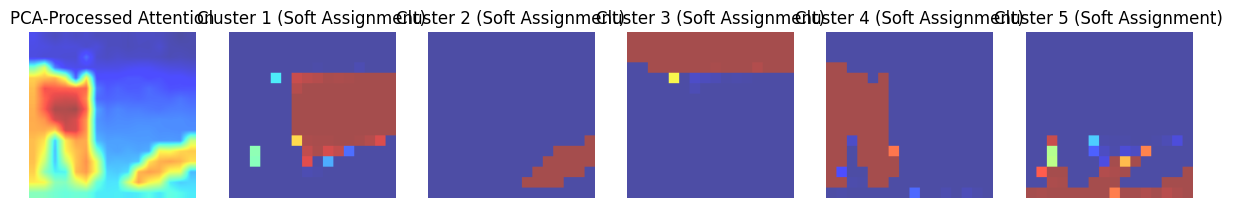

['a', 'grizzly', 'bear', 'catching', 'a', 'salmon', 'from', 'a', 'clear', 'river', 'surrounded', 'by', 'a', 'forest']


<ipython-input-10-b1d4eac1c76b>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_relevance = torch.tensor(image_relevance, dtype=torch.float32, device="cpu")


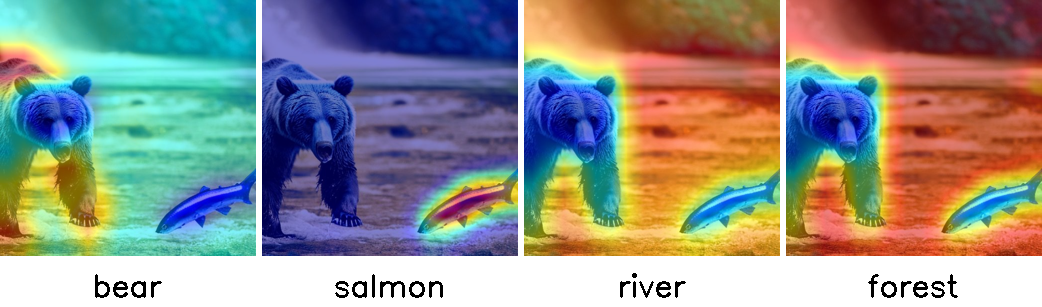


(51, 224, 16)


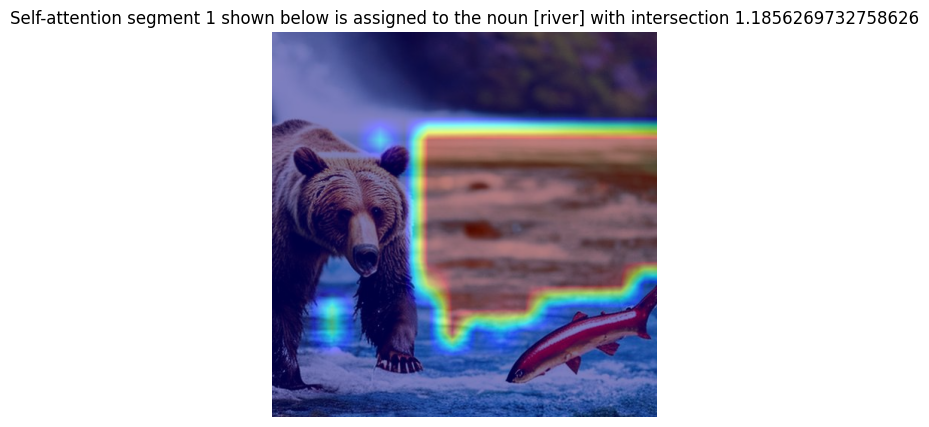

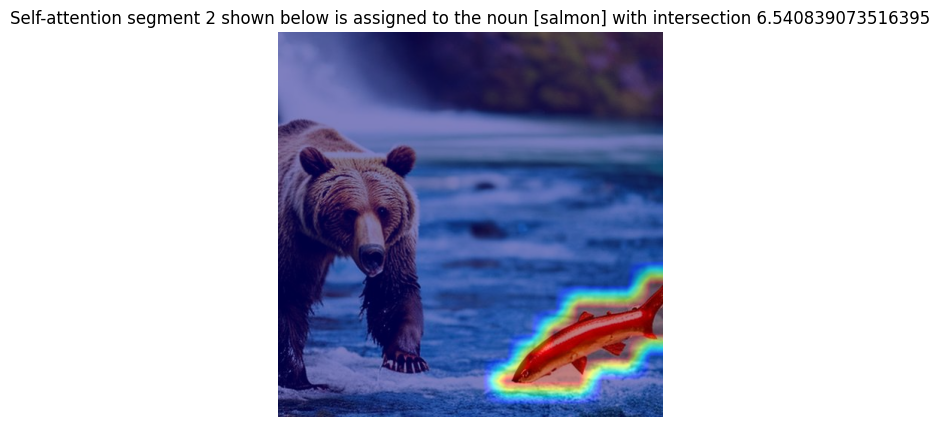

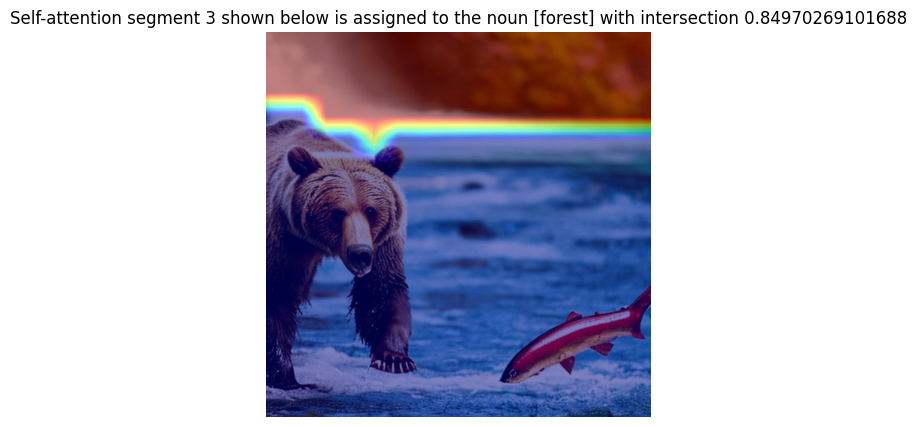

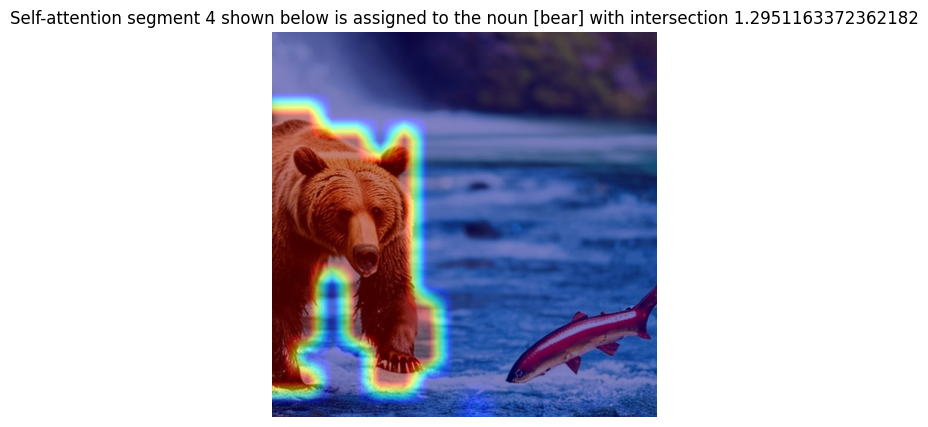

In [ ]:
output_folder_name="a grizzly bear catching a salmon from a clear river surrounded by a forest"
prompt="a grizzly bear catching a salmon from a clear river surrounded by a forest"
SEEDS = [i for i in range(1)]
token_indices=[3,6,10,14]
for seed in SEEDS:
    SA_map = torch.load(f"outputs/{output_folder_name}/self_attention_maps_{output_folder_name}_{seed}.pt",map_location=torch.device('cpu'))
    CA_maps_path = f"outputs/{output_folder_name}/cross_attention_maps_{output_folder_name}_{seed}.npy"
    image_path = f"outputs/{output_folder_name}/{seed}.jpg"
    orig_image = Image.open(image_path).convert('RGB')  # Convert to RGB
    orig_image.show()
    res=16
    self_attention_segments=visualize_SA_map_GMM(SA_map.detach().numpy(),k_clusters=5)
    attention_maps=show_cross_attention(prompt=prompt,
                     CA_maps_path=CA_maps_path,
                     indices_to_alter=token_indices,
                     res=res,
                     from_where=("up", "down", "mid"),
                     orig_image=image_path)
    temp=np.zeros([res,res])
    print(attention_maps.shape)
    cross_attention_maps=np.zeros([len(token_indices),res,res])
    cross_attention_maps = [otsu_thresholding(attention_maps[50, 16*(i-1):16*(i-1)+16 , :]) for i in token_indices]
    self_attention_segments = self_attention_segments.transpose(2,0,1)
    assignments = assign_segments_to_nouns(self_attention_segments, cross_attention_maps)
    for seg_idx, noun_idx in assignments:
        text=f"Self-attention segment {seg_idx+1} shown below is assigned to the noun [{(prompt.split())[token_indices[noun_idx]-1]}] with intersection {calculate_intersection(self_attention_segments[seg_idx],attention_maps[50, res*(token_indices[noun_idx]-1):res*(token_indices[noun_idx]-1)+res , :])}"
        overlay_SA_over_image(self_attention_segments[seg_idx],orig_image,text)
